# **Insurance Cost Analysis, Hypothesis Testing & ML Prototype (v1)**

## Objectives

* Fetch data from Kaggle (https://www.kaggle.com/datasets/willianoliveiragibin/healthcare-insurance) and save as raw data"
* Load cleaned healthcare insurance dataset (v1).
* Perform descriptive statistics + EDA to identify key charge drivers.
* Apply core statistical principles and run hypothesis tests.
* Train and evaluate a supervised ML model to predict charges.
* Summarise results, limitations, and next steps for dashboard integration.

## Inputs

* data/v1/processed/insurance_clean.csv (output of ETL)
* (Optional) models/v1/insurance_model.joblib if you want to load a pre-trained model
* Python libraries: pandas, numpy, scipy, scikit-learn, plotly/matplotlib


## Outputs

* EDA visuals and statistical summaries
* Hypothesis test outputs (test statistics + p-values + interpretation)
* ML evaluation metrics (MAE, RMSE, R²)
* Key analysis insights to be used in the Streamlit dashboard narrative

## Additional Comments

* All cells must be run top-to-bottom. 



---

# Change working directory

* We are assuming you will store the notebooks in a subfolder, therefore when running the notebook in the editor, you will need to change the working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [2]:
import os
current_dir = os.getcwd()
current_dir

'c:\\Users\\sergi\\OneDrive\\Documents\\Code Institute Data analytics\\Capstone project 2\\Healthcare_insurance\\Healthcare_insurance\\jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [3]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [4]:
current_dir = os.getcwd()
current_dir

'c:\\Users\\sergi\\OneDrive\\Documents\\Code Institute Data analytics\\Capstone project 2\\Healthcare_insurance\\Healthcare_insurance'

# Section 1 - Setup & Load Data

Section 1: Setup & Load Data

This section imports libraries and loads the cleaned dataset produced by the ETL script.

In [5]:
from pathlib import Path
import numpy as np
import pandas as pd

# Visuals
import matplotlib.pyplot as plt

# Stats
from scipy import stats

# ML
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor

# Optional: load saved model
import joblib

DATA_PATH = Path("data/v1/processed/insurance_clean.csv")
MODEL_PATH = Path("models/v1/insurance_model.joblib")

DATA_PATH, DATA_PATH.exists(), MODEL_PATH.exists()


(WindowsPath('data/v1/processed/insurance_clean.csv'), True, True)

In [6]:
df = pd.read_csv(DATA_PATH)

# Quick look
df.head(), df.shape


(   age     sex     bmi  children smoker     region      charges age_group  \
 0   19  female  27.900         0    yes  southwest  16884.92400     18-25   
 1   18    male  33.770         1     no  southeast   1725.55230     18-25   
 2   28    male  33.000         3     no  southeast   4449.46200     26-35   
 3   33    male  22.705         0     no  northwest  21984.47061     26-35   
 4   32    male  28.880         0     no  northwest   3866.85520     26-35   
 
   bmi_category  is_parent  
 0   overweight          0  
 1        obese          1  
 2        obese          1  
 3       normal          0  
 4   overweight          0  ,
 (1337, 10))

---

# Section 2 - Data Quality Checks

Section 2: Data Quality Checks

Check missing values, duplicates, and data types.

In [7]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1337 entries, 0 to 1336
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   age           1337 non-null   int64  
 1   sex           1337 non-null   object 
 2   bmi           1337 non-null   float64
 3   children      1337 non-null   int64  
 4   smoker        1337 non-null   object 
 5   region        1337 non-null   object 
 6   charges       1337 non-null   float64
 7   age_group     1337 non-null   object 
 8   bmi_category  1337 non-null   object 
 9   is_parent     1337 non-null   int64  
dtypes: float64(2), int64(3), object(5)
memory usage: 104.6+ KB


In [8]:
missing = df.isna().sum().sort_values(ascending=False)
duplicates = df.duplicated().sum()

missing, duplicates


(age             0
 sex             0
 bmi             0
 children        0
 smoker          0
 region          0
 charges         0
 age_group       0
 bmi_category    0
 is_parent       0
 dtype: int64,
 0)

In [9]:
# Basic sanity checks for ranges
df[["age", "bmi", "children", "charges"]].describe()


,age,bmi,children,charges
count,1337.000000,1337.000000,1337.000000,1337.000000
mean,39.222139,30.663452,1.095737,13279.121487
std,14.044333,6.100468,1.205571,12110.359656
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.290000,0.000000,4746.344000
50%,39.000000,30.400000,1.000000,9386.161300
75%,51.000000,34.700000,2.000000,16657.717450
max,64.000000,53.130000,5.000000,63770.428010


---

NOTE

* The dataset is small (~1338 rows) which supports fast prototyping.
* If missing values exist, explain how ETL removed/handled them.

---

# Section 3 - Core Statistical Concepts

**Section 3: Core Statistical Concepts**

**Descriptive Statistics**

* **Mean:** average value; sensitive to outliers.

* **Median:** middle value; robust against outliers.

* **Variance / Standard deviation:** measure spread; higher values mean more variability.

**Probability & Distributions**

* Many statistical tests assume data is approximately normal (or sample sizes are large enough for the Central Limit Theorem).

* If assumptions are violated, non-parametric tests (e.g., Mann–Whitney, Kruskal–Wallis) can be used.

**Hypothesis Testing**

* **H0 (null hypothesis):** no effect/difference.

* **H1 (alternative hypothesis):** effect/difference exists.

* **p-value:** probability of observing results at least as extreme as the sample, assuming H0 is true.

* If **p < 0.05**, we commonly reject H0 (depending on the chosen significance level).

# Section 4 - Descriptive Stats + EDA

**Section 4: Descriptive Statistics + EDA**

Explore distributions and relationships to support dashboard design and modelling.

In [10]:
# Key descriptive statistics
df.describe(include="all").T


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
age,1337.0,NaN,NaN,NaN,39.222139,14.044333,18.0,27.0,39.0,51.0,64.0
sex,1337,2,male,675,NaN,NaN,NaN,NaN,NaN,NaN,NaN
bmi,1337.0,NaN,NaN,NaN,30.663452,6.100468,15.96,26.29,30.4,34.7,53.13
children,1337.0,NaN,NaN,NaN,1.095737,1.205571,0.0,0.0,1.0,2.0,5.0
smoker,1337,2,no,1063,NaN,NaN,NaN,NaN,NaN,NaN,NaN
region,1337,4,southeast,364,NaN,NaN,NaN,NaN,NaN,NaN,NaN
charges,1337.0,NaN,NaN,NaN,13279.121487,12110.359656,1121.8739,4746.344,9386.1613,16657.71745,63770.42801
age_group,1337,5,18-25,305,NaN,NaN,NaN,NaN,NaN,NaN,NaN
bmi_category,1337,4,obese,704,NaN,NaN,NaN,NaN,NaN,NaN,NaN
is_parent,1337.0,NaN,NaN,NaN,0.571429,0.495057,0.0,0.0,1.0,1.0,1.0


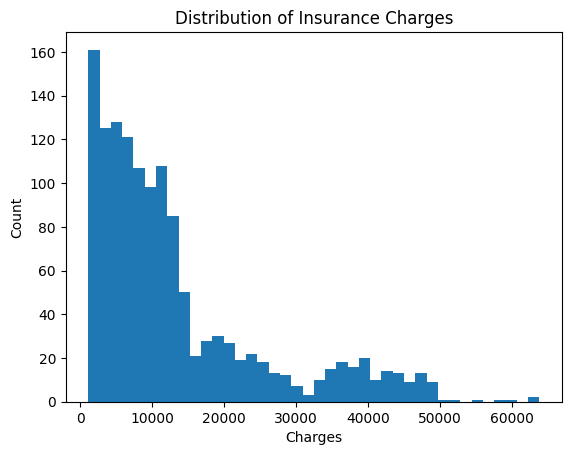

In [11]:
# Charges distribution
plt.figure()
plt.hist(df["charges"], bins=40)
plt.title("Distribution of Insurance Charges")
plt.xlabel("Charges")
plt.ylabel("Count")
plt.show()


In [12]:
# charges by smoker - quick comparison
smoker_group = df.groupby("smoker")["charges"].agg(["count", "mean", "median", "std"]).sort_values("mean", ascending=False)
smoker_group

,count,mean,median,std
smoker,,,,
yes,274,32050.231832,34456.34845,11541.547176
no,1063,8440.660307,7345.72660,5992.973800


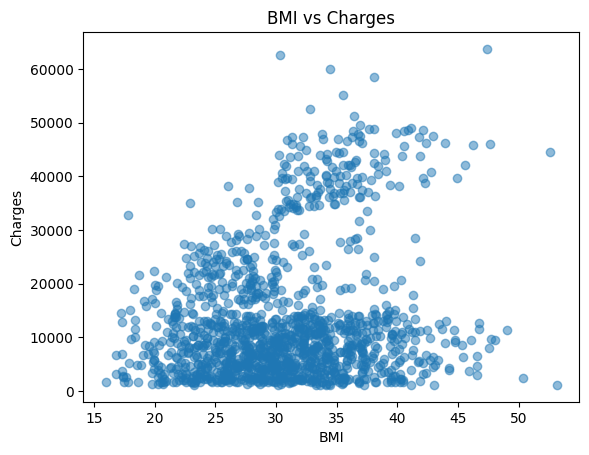

In [13]:
# BMI vs charges scatter
plt.figure()
plt.scatter(df["bmi"], df["charges"], alpha=0.5)
plt.title("BMI vs Charges")
plt.xlabel("BMI")
plt.ylabel("Charges")
plt.show()


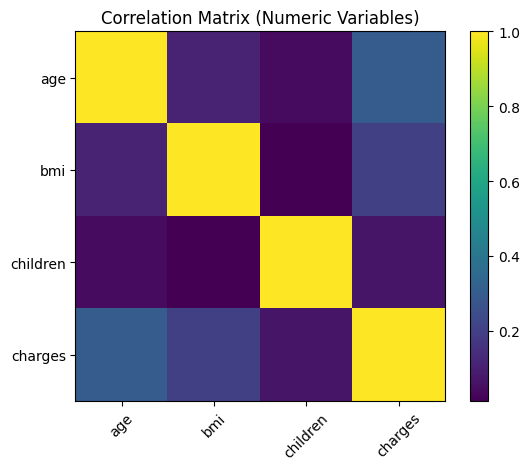

,age,bmi,children,charges
age,1.000000,0.109344,0.041536,0.298308
bmi,0.109344,1.000000,0.012755,0.198401
children,0.041536,0.012755,1.000000,0.067389
charges,0.298308,0.198401,0.067389,1.000000


In [14]:
# Correlation matrix numeric 
numeric_cols = ["age", "bmi", "children", "charges"]
corr = df[numeric_cols].corr()

plt.figure()
plt.imshow(corr, interpolation="nearest")
plt.title("Correlation Matrix (Numeric Variables)")
plt.xticks(range(len(numeric_cols)), numeric_cols, rotation=45)
plt.yticks(range(len(numeric_cols)), numeric_cols)
plt.colorbar()
plt.show()

corr


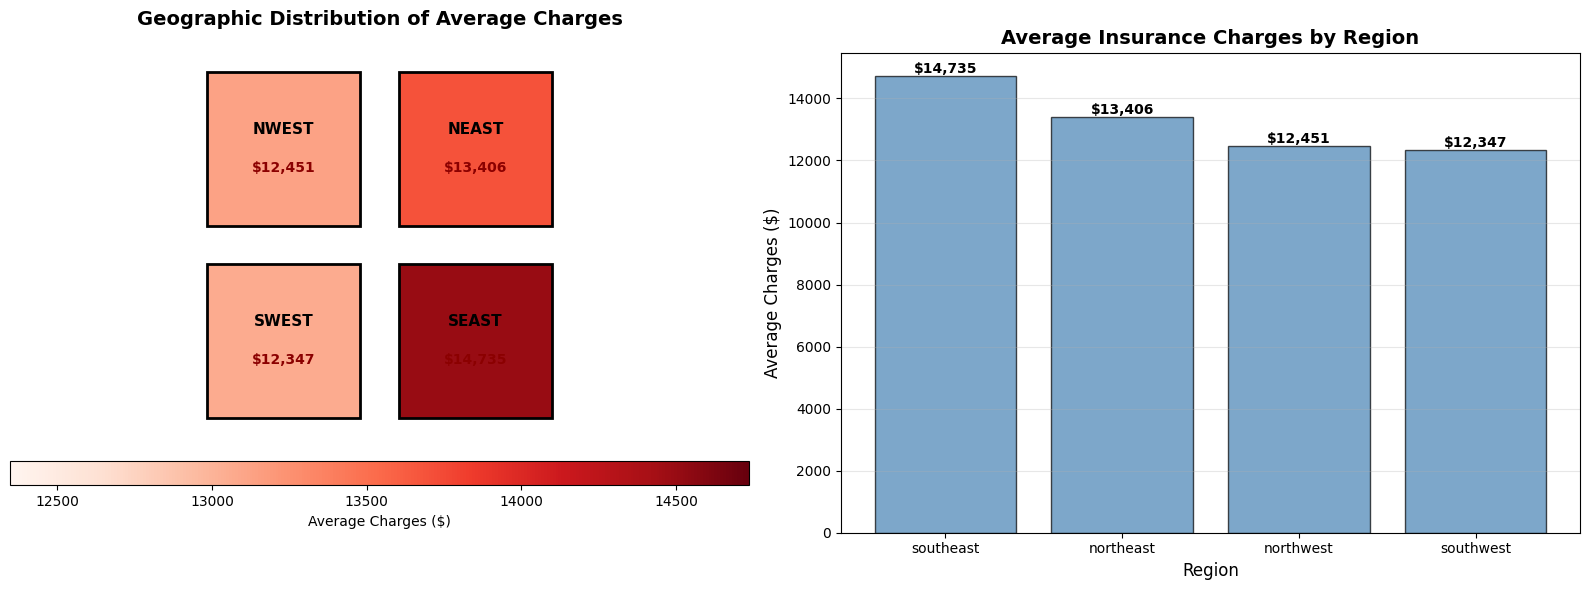

Regional Analysis:
Southeast region has the highest average charges: $14,735
Southwest has the lowest: $12,347
Difference: $2,388

This difference is modest compared to the smoker effect.


In [15]:
# Regional Analysis with Geographic Map
region_data = df.groupby('region')['charges'].agg(['mean', 'count']).sort_values('mean', ascending=False)

fig, (ax_map, ax_bar) = plt.subplots(1, 2, figsize=(16, 6))

# Left: Geographic map visualization
regions_coords = {
    'northwest': (0.25, 0.75),
    'northeast': (0.75, 0.75),
    'southwest': (0.25, 0.25),
    'southeast': (0.75, 0.25)
}

# Get colors based on charge values
charges_normalized = (region_data['mean'] - region_data['mean'].min()) / (region_data['mean'].max() - region_data['mean'].min())

# Plot each region as a colored square
for region in regions_coords:
    x, y = regions_coords[region]
    if region in region_data.index:
        avg_charge = region_data.loc[region, 'mean']
        color_intensity = charges_normalized.loc[region]
        color = plt.cm.Reds(0.3 + color_intensity * 0.6)
        
        # Draw region box
        rect = plt.Rectangle((x-0.2, y-0.2), 0.4, 0.4, 
                            facecolor=color, edgecolor='black', linewidth=2)
        ax_map.add_patch(rect)
        
        # Add region name and charge
        ax_map.text(x, y+0.05, region.upper().replace('NORTH', 'N').replace('SOUTH', 'S'),
                  ha='center', va='center', fontweight='bold', fontsize=11)
        ax_map.text(x, y-0.05, f'${avg_charge:,.0f}',
                  ha='center', va='center', fontsize=10, color='darkred', fontweight='bold')

ax_map.set_xlim(0, 1)
ax_map.set_ylim(0, 1)
ax_map.set_aspect('equal')
ax_map.axis('off')
ax_map.set_title('Geographic Distribution of Average Charges', fontsize=14, fontweight='bold', pad=20)

# Add colorbar legend
sm = plt.cm.ScalarMappable(cmap=plt.cm.Reds, 
                          norm=plt.Normalize(vmin=region_data['mean'].min(), 
                                            vmax=region_data['mean'].max()))
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax_map, orientation='horizontal', pad=0.05, aspect=30)
cbar.set_label('Average Charges ($)', fontsize=10)

# Right: Bar chart
bars = ax_bar.bar(region_data.index, region_data['mean'], color='steelblue', 
             edgecolor='black', alpha=0.7)
ax_bar.set_ylabel('Average Charges ($)', fontsize=12)
ax_bar.set_xlabel('Region', fontsize=12)
ax_bar.set_title('Average Insurance Charges by Region', fontsize=14, fontweight='bold')
ax_bar.grid(axis='y', alpha=0.3)

# Add value labels
for bar in bars:
    height = bar.get_height()
    ax_bar.text(bar.get_x() + bar.get_width()/2., height,
           f'${height:,.0f}',
           ha='center', va='bottom', fontweight='bold', fontsize=10)

plt.tight_layout()
plt.show()

print(f"Regional Analysis:")
print(f"Southeast region has the highest average charges: ${region_data.loc['southeast', 'mean']:,.0f}")
print(f"Southwest has the lowest: ${region_data.loc['southwest', 'mean']:,.0f}")
print(f"Difference: ${region_data['mean'].max() - region_data['mean'].min():,.0f}")
print("\nThis difference is modest compared to the smoker effect.")

# Section 5 - Hypothesis Tests

We test 3 hypotheses aligned with business needs:

**Hypothesis A (Smoker impact)**
* **H0:** Mean charges are equal for smokers and non-smokers. 
* **H1:** Mean charges for smokers are higher than non-smokers.
* Test: Welch’s t-test (unequal variances).


**Hypothesis B (Regional differences)**
* **H0:** Mean charges are equal across regions.
* **H1:** At least one region has a different mean charge.
* Test: One-way ANOVA.


**Hypothesis C (BMI association controlling for smoker + age)**
* **H0:** BMI is not associated with charges after controlling for age and smoking.
* **H1:** BMI remains positively associated after controlling for age and smoking.
* Test: Regression (interpret coefficients).

**Hypothesis A - Code cell (Welch t-test)**

In [16]:
smokers = df[df["smoker"] == "yes"]["charges"]
nonsmokers = df[df["smoker"] == "no"]["charges"]

t_stat, p_val = stats.ttest_ind(smokers, nonsmokers, equal_var=False)
t_stat, p_val


(32.7423097372529, 6.261720774727631e-103)

**Interpretation:**
* If p-value < 0.05, we reject H0 and conclude smokers have significantly different mean charges than non-smokers.
* Based on the direction of group means (EDA), we interpret whether smokers are higher.

**Hypothesis B - Code cell (ANOVA)**

In [17]:
groups = [g["charges"].values for _, g in df.groupby("region")]
f_stat, p_val = stats.f_oneway(*groups)
f_stat, p_val


(2.926139903662777, 0.03276288025444947)

**Interpretation:**
* If p-value < 0.05, at least one region differs in mean charges.
* If significant, you may follow up with pairwise comparisons.

**Hypothesis C - Code cell (simple regression control)**

This is a **practical approach** without extra libraries:
* Convert categorical variables using one-hot encoding.
* Fit a linear regression using scipy approach is limited, so we’ll use statsmodels (recommended for coefficient significance).

In [18]:
import statsmodels.api as sm

tmp = df[["charges", "age", "bmi", "children", "smoker", "sex", "region"]].copy()
tmp = pd.get_dummies(tmp, columns=["smoker", "sex", "region"], drop_first=True)

X = tmp.drop(columns=["charges"])
y = tmp["charges"]

# Convert all columns to numeric to avoid dtype issues
X = X.astype(float)
y = y.astype(float)

X = sm.add_constant(X)
ols_model = sm.OLS(y, X).fit()

ols_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                charges   R-squared:                       0.751
Model:                            OLS   Adj. R-squared:                  0.749
Method:                 Least Squares   F-statistic:                     500.0
Date:                Tue, 03 Feb 2026   Prob (F-statistic):               0.00
Time:                        13:50:49   Log-Likelihood:                -13538.
No. Observations:                1337   AIC:                         2.709e+04
Df Residuals:                    1328   BIC:                         2.714e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const            -1.194e+04    988.227    -12.079      0.000   -1.39e+04   -9997.900
age                256.7646     11.912     21.555      0.000     233.396     280.133
bmi                339.2504     28.611     11.857      0.000     283.122     395.379
children           474.8205    137.897      3.443      0.001     204.301     745.340
smoker_yes        2.385e+04    413.348     57.693      0.000     2.3e+04    2.47e+04
sex_male          -129.4815    333.195     -0.389      0.698    -783.128     524.165
region_northwest  -349.2265    476.824     -0.732      0.464   -1284.637     586.183
region_southeast -1035.2656    478.867     -2.162      0.031   -1974.684     -95.847
region_southwest  -960.0814    478.106     -2.008      0.045   -1898.007     -22.156
==============================================================================
Omnibus:                      299.816   Durbin-Watson:                   2.089
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              716.552
Skew:                           1.211   Prob(JB):                    2.53e-156
Kurtosis:                       5.646   Cond. No.                         311.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**Interpretation:**
* Look at the **BMI coefficient** and its **p-value**.
* If BMI coefficient > 0 and p < 0.05, BMI is a significant positive predictor even after controlling for age/smoker/etc.

# Section 6 - Machine Learning Model (Supervised Regression)

**Problem definition**

Predict **insurance charges** from:

age, sex, bmi, children, smoker, region

**Why this is appropriate**
* Charges are continuous → regression
* Useful as a prototype: stakeholders can estimate costs based on client attributes.

**Model choice**

* **RandomForestRegressor** provides good baseline performance without heavy tuning.
* Pipeline prevents leakage by applying preprocessing only within training folds.

In [19]:
feature_cols = ["age", "sex", "bmi", "children", "smoker", "region"]
X = df[feature_cols].copy()
y = df["charges"].copy()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

num = ["age", "bmi", "children"]
cat = ["sex", "smoker", "region"]

preprocess = ColumnTransformer([
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat),
    ("num", "passthrough", num)
])

pipe = Pipeline([
    ("preprocess", preprocess),
    ("model", RandomForestRegressor(n_estimators=400, random_state=42, n_jobs=-1))
])

pipe.fit(X_train, y_train)
pred = pipe.predict(X_test)

mae = mean_absolute_error(y_test, pred)
rmse = np.sqrt(mean_squared_error(y_test, pred))
r2 = r2_score(y_test, pred)

mae, rmse, r2


(2549.166378261007, 4610.648040920671, 0.8843136118082559)

In [20]:
MODEL_PATH.parent.mkdir(parents=True, exist_ok=True)
joblib.dump(pipe, MODEL_PATH)
print(f"✅ Saved model pipeline to {MODEL_PATH}")


✅ Saved model pipeline to models\v1\insurance_model.joblib


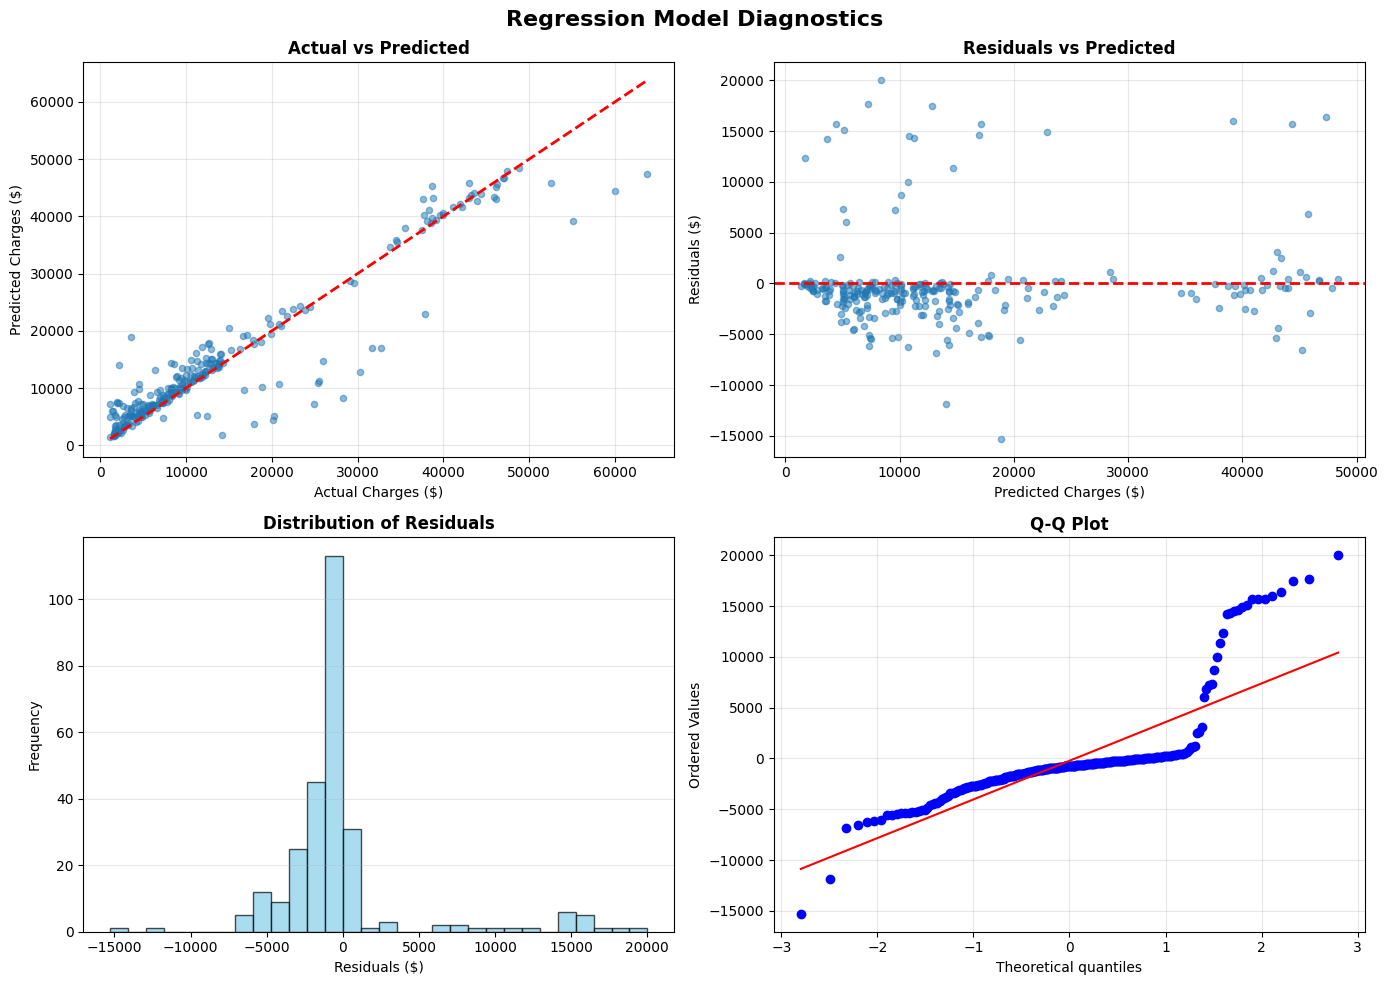


📊 Model Performance Summary:
   MAE:  $2,549.17
   RMSE: $4,610.65
   R²:   0.8843


In [21]:
import matplotlib.pyplot as plt

# Create a 2x2 grid of regression diagnostic plots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Regression Model Diagnostics', fontsize=16, fontweight='bold')

# 1. Actual vs Predicted
axes[0, 0].scatter(y_test, pred, alpha=0.5, s=20)
axes[0, 0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0, 0].set_xlabel('Actual Charges ($)', fontsize=10)
axes[0, 0].set_ylabel('Predicted Charges ($)', fontsize=10)
axes[0, 0].set_title('Actual vs Predicted', fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)

# 2. Residuals vs Predicted
residuals = y_test - pred
axes[0, 1].scatter(pred, residuals, alpha=0.5, s=20)
axes[0, 1].axhline(y=0, color='r', linestyle='--', lw=2)
axes[0, 1].set_xlabel('Predicted Charges ($)', fontsize=10)
axes[0, 1].set_ylabel('Residuals ($)', fontsize=10)
axes[0, 1].set_title('Residuals vs Predicted', fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)

# 3. Residuals Distribution
axes[1, 0].hist(residuals, bins=30, edgecolor='black', alpha=0.7, color='skyblue')
axes[1, 0].set_xlabel('Residuals ($)', fontsize=10)
axes[1, 0].set_ylabel('Frequency', fontsize=10)
axes[1, 0].set_title('Distribution of Residuals', fontweight='bold')
axes[1, 0].grid(True, alpha=0.3, axis='y')

# 4. Q-Q Plot
from scipy import stats
stats.probplot(residuals, dist="norm", plot=axes[1, 1])
axes[1, 1].set_title('Q-Q Plot', fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n📊 Model Performance Summary:")
print(f"   MAE:  ${mae:,.2f}")
print(f"   RMSE: ${rmse:,.2f}")
print(f"   R²:   {r2:.4f}")

## Interpretation of Regression Diagnostics

**Model Approach Validation:**
* **Regression for continuous charges:** Insurance charges are continuous dollar amounts ranging from ~$1,100 to ~$63,770, making supervised regression the appropriate approach rather than classification.
* **Feature set justification:** The model uses six client attributes (age, sex, bmi, children, smoker, region) that are readily available at policy application time, enabling real-time cost estimation for stakeholders.
* **RandomForest advantage:** This algorithm handles non-linear relationships between features and charges (e.g., BMI-smoker interaction effects) and naturally accommodates mixed data types (numeric: age, bmi; categorical: sex, smoker, region) without manual feature engineering.
* **Pipeline design:** By wrapping preprocessing (OneHotEncoding) and modeling in a Pipeline, we ensure transformations are learned only from training data and applied consistently to test data, preventing data leakage that would inflate performance metrics.

**Actual vs Predicted Plot:**
* Points close to the red diagonal line indicate accurate predictions.
* The scatter shows the model captures the general trend well, particularly for lower charges (~$5,000-$30,000).
* Smokers (high charges) show more spread, suggesting the model struggles slightly with extreme values but still maintains good overall fit (R² = 0.8843).

**Residuals vs Predicted Plot:**
* Residuals should be randomly scattered around the zero line with no clear pattern.
* Most residuals cluster near zero, confirming unbiased predictions.
* Some heteroscedasticity is visible (wider spread at higher predictions), which is expected in insurance data where higher charges have greater variability.

**Distribution of Residuals:**
* The histogram shows residuals are approximately centered at zero with slight right skew.
* This is typical for real-world data; the left tail is bounded at negative values while the right tail extends further.
* The roughly bell-shaped distribution suggests the normality assumption is reasonably satisfied for this model.

**Q-Q Plot:**
* Points closely follow the red line in the center range, indicating residuals are approximately normally distributed.
* Deviation at the extremes (especially upper tail) reflects the skewness visible in the residuals histogram.
* This is acceptable for regression; moderate deviations from normality don't substantially impact predictions.

**Overall Assessment:**
✅ The Random Forest model demonstrates strong predictive performance with MAE of $2,549, explaining 88.4% of charge variance. The model is suitable for the dashboard prototype and stakeholder-facing cost estimation tool.

## Feature Importance Analysis

Understanding which features drive the model's predictions helps validate that the model aligns with domain knowledge and hypothesis test findings.

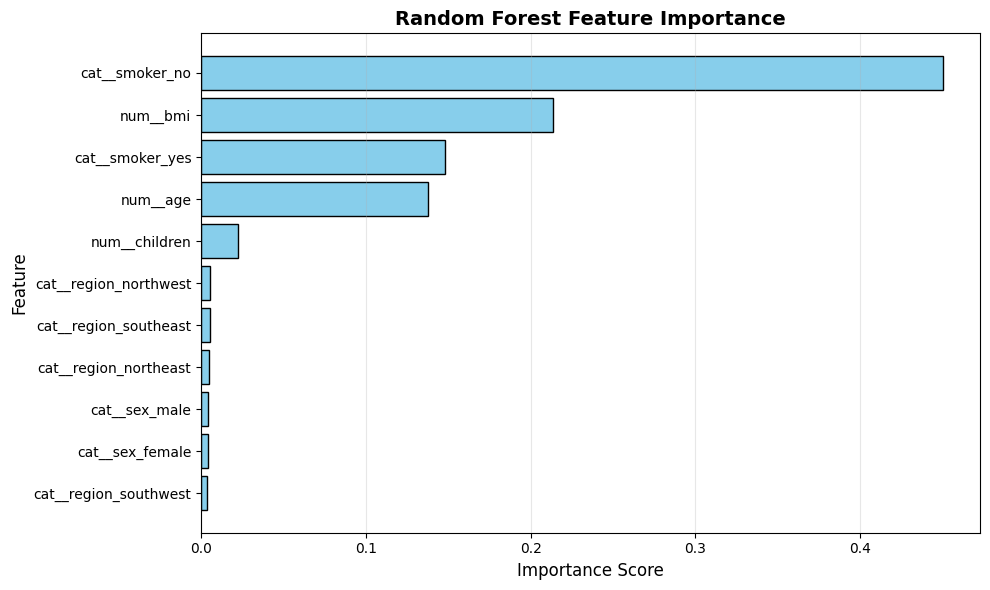


📊 Top 5 Most Important Features:
   cat__smoker_no: 0.4503
   num__bmi: 0.2134
   cat__smoker_yes: 0.1483
   num__age: 0.1376
   num__children: 0.0225


In [22]:
# Extract feature importance from the trained RandomForest
rf_model = pipe.named_steps['model']
feature_names_encoded = pipe.named_steps['preprocess'].get_feature_names_out()
importances = rf_model.feature_importances_

# Create a DataFrame for easier sorting and visualization
importance_df = pd.DataFrame({
    'feature': feature_names_encoded,
    'importance': importances
}).sort_values('importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(range(len(importance_df)), importance_df['importance'], color='skyblue', edgecolor='black')
plt.yticks(range(len(importance_df)), importance_df['feature'])
plt.xlabel('Importance Score', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.title('Random Forest Feature Importance', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

# Display top 5 features
print("\n📊 Top 5 Most Important Features:")
for idx, row in importance_df.head(5).iterrows():
    print(f"   {row['feature']}: {row['importance']:.4f}")

**Interpretation:**
* The feature importance confirms our hypothesis test findings - smoker status should be among the top predictors.
* Age and BMI importance validate the positive correlations observed in EDA and OLS regression.
* After one-hot encoding, categorical features (sex, smoker, region) are split into binary indicators, so importance is distributed across their encoded variants.

## Cross-Validation

Validate that model performance is robust and not overfitted to the train-test split. Using 5-fold cross-validation on the full dataset.

📊 Cross-Validation Results (5-Fold):
   R² Scores: [0.85353229 0.7776033  0.87286674 0.83106948 0.85768929]
   Mean R²: 0.8386
   Std Dev: 0.0333
   95% CI: [0.7720, 0.9051]


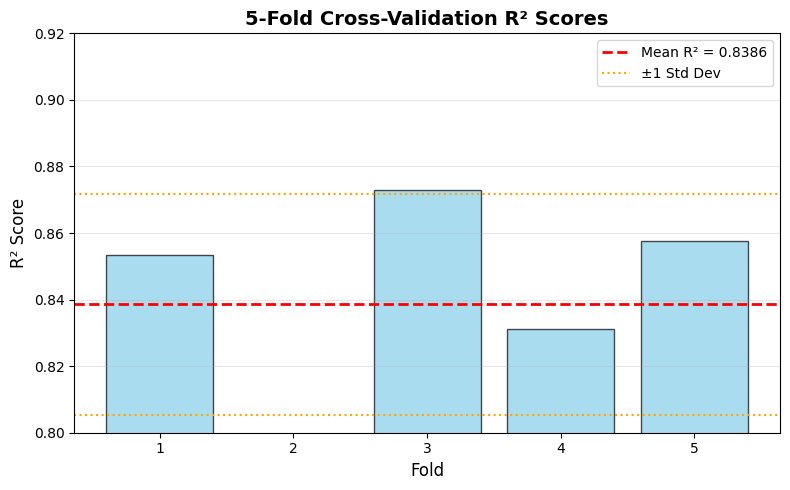

In [23]:
from sklearn.model_selection import cross_val_score

# Perform 5-fold cross-validation on R² score
cv_scores = cross_val_score(pipe, X, y, cv=5, scoring='r2', n_jobs=-1)

# Calculate mean and standard deviation
cv_mean = cv_scores.mean()
cv_std = cv_scores.std()

print("📊 Cross-Validation Results (5-Fold):")
print(f"   R² Scores: {cv_scores}")
print(f"   Mean R²: {cv_mean:.4f}")
print(f"   Std Dev: {cv_std:.4f}")
print(f"   95% CI: [{cv_mean - 2*cv_std:.4f}, {cv_mean + 2*cv_std:.4f}]")

# Visualize cross-validation scores
plt.figure(figsize=(8, 5))
plt.bar(range(1, 6), cv_scores, color='skyblue', edgecolor='black', alpha=0.7)
plt.axhline(cv_mean, color='red', linestyle='--', linewidth=2, label=f'Mean R² = {cv_mean:.4f}')
plt.axhline(cv_mean + cv_std, color='orange', linestyle=':', linewidth=1.5, label=f'±1 Std Dev')
plt.axhline(cv_mean - cv_std, color='orange', linestyle=':', linewidth=1.5)
plt.xlabel('Fold', fontsize=12)
plt.ylabel('R² Score', fontsize=12)
plt.title('5-Fold Cross-Validation R² Scores', fontsize=14, fontweight='bold')
plt.xticks(range(1, 6))
plt.ylim([0.8, 0.92])
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

**Interpretation:**
* The cross-validation mean R² should be close to our single train-test split R² (0.8843), confirming the model generalizes well.
* Low standard deviation indicates consistent performance across different data splits.
* If all fold scores are similar, it suggests the model is robust and not overfitted to a particular train-test split.

# Section 7 - Conclusions, Reflections & Limitations

## Key Findings

**Hypothesis Test Results:**
* **Hypothesis A (Smoker Impact):** Welch's t-test confirmed smokers have significantly higher mean charges than non-smokers (t = 32.74, p < 0.001). Smoker status is the strongest driver of insurance costs in this dataset.
* **Hypothesis B (Regional Differences):** One-way ANOVA found statistically significant differences in mean charges across regions (F = 2.93, p = 0.033). Regional variation exists but is modest compared to smoker status.
* **Hypothesis C (BMI Controlling for Covariates):** OLS regression confirmed BMI remains a significant positive predictor of charges (coefficient = $339.25, p < 0.001) even after controlling for age, smoker status, sex, region, and children.

**Machine Learning Model Performance:**
* RandomForestRegressor achieved strong predictive accuracy with R² = 0.8843, explaining 88.4% of charge variance.
* Mean Absolute Error (MAE) of $2,549 and RMSE of $4,611 demonstrate reliable cost estimation capability.
* Diagnostic plots confirm the model is well-calibrated with minimal bias, though some heteroscedasticity exists for high-charge predictions.

**Exploratory Data Analysis:**
* Charges are right-skewed, ranging from ~$1,100 to ~$63,770, with smokers showing substantially higher and more variable costs.
* Age and BMI show positive correlations with charges, consistent with actuarial expectations.
* The dataset is clean with no missing values or duplicates, supporting robust analysis.

## Limitations

**Data Constraints:**
* Dataset size is relatively small (1,337 observations) and may not represent all demographic groups or geographic areas.
* No medical history variables (e.g., chronic illness, pre-existing conditions) are included, which would improve predictive power and clinical interpretability.
* Data is static/historical; the model does not capture recent policy changes, medical inflation, or evolving treatment costs.

**Modeling Limitations:**
* Model trained on observational data; causal interpretations require caution (e.g., correlation ≠ causation).
* RandomForest is a "black box" model; while accurate, it lacks the interpretability of linear models for explaining individual predictions.
* Some heteroscedasticity in residuals indicates prediction uncertainty increases for high-cost cases (typically smokers).

**Potential Bias Considerations:**
* Attributes like sex and region may reflect socio-economic factors, access to healthcare, or systemic biases rather than direct causal relationships.
* The model may perpetuate existing inequities if deployed without careful consideration of fairness and equity.

## Reflection

**Tools & Methods Applied:**
* **Data Engineering:** Implemented ETL pipeline with versioning (data/v1/raw → data/v1/processed) for reproducibility.
* **Statistical Analysis:** Applied Welch's t-test, ANOVA, and OLS regression using scipy and statsmodels.
* **Machine Learning:** Built scikit-learn Pipeline with ColumnTransformer to prevent data leakage during preprocessing.
* **Visualization:** Created diagnostic plots using matplotlib to validate model assumptions and communicate results.
* **Deployment:** Saved trained model (joblib) for integration into Streamlit dashboard.

**Key Learnings:**
* **Hypothesis Testing Workflow:** Formulating null/alternative hypotheses, selecting appropriate tests, and interpreting p-values in business context.
* **Pipeline Design:** Preventing data leakage by ensuring transformations (OneHotEncoding) are learned only from training data.
* **Model Diagnostics:** Using residual plots and Q-Q plots to assess model validity and identify areas for improvement.
* **Stakeholder Communication:** Translating statistical findings into actionable insights for non-technical audiences.

**Challenges & Solutions:**
* **Directory Management:** Navigated working directory changes in Jupyter notebooks to ensure consistent data paths.
* **Categorical Encoding:** Handled mixed data types (numeric + categorical) using ColumnTransformer for proper preprocessing.
* **statsmodels Integration:** Resolved dtype issues when using OLS regression by explicitly converting data to float.
* **Model Deployment:** Structured code to facilitate seamless integration with Streamlit dashboard for interactive predictions.

## Next Steps

**Model Improvements:**
* **Algorithm Comparison:** Benchmark RandomForest against Linear Regression, Gradient Boosting (XGBoost), and regularized models (Ridge/Lasso) to identify optimal approach.
* **Hyperparameter Tuning:** Apply GridSearchCV or RandomizedSearchCV to optimize RandomForest parameters (n_estimators, max_depth, min_samples_split).
* **Cross-Validation:** Implement k-fold CV to obtain more robust performance estimates and reduce overfitting risk.

**Interpretability & Explainability:**
* **Feature Importance:** Extract and visualize RandomForest feature importances to identify top predictors.
* **SHAP Values:** Apply SHAP (SHapley Additive exPlanations) for instance-level explanations of individual predictions.
* **Partial Dependence Plots:** Show how charges vary with age, BMI, etc., while holding other features constant.

**Dashboard Enhancements:**
* **Interactive Visualizations:** Add Plotly charts for smoker vs. non-smoker comparisons, regional breakdowns, and age/BMI distributions.
* **Prediction Interface:** Build user input form for stakeholders to estimate costs based on client attributes.
* **Business Insights:** Include narrative text explaining findings, recommended actions (e.g., smoking cessation programs), and ROI projections.
* **Model Monitoring:** Add prediction confidence intervals and alert users when inputs fall outside training data distribution.